In [73]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge,Lasso,ElasticNet, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

import mglearn
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family']='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

import warnings
warnings.simplefilter('ignore')

# 웹크롤링

In [118]:
import requests
import pandas as pd
from xml.etree import ElementTree
from bs4 import BeautifulSoup

url = 'https://www.weather.go.kr/weather/forecast/mid-term-rss3.jsp?stnId=109'
res = requests.get(url)
bs = BeautifulSoup( res.content, 'html.parser')

lists = []
for l in bs.findAll('location'):
    for d in l.findAll('data'):
        lists.append( {'도시':l.city.string, '날짜':d.tmef.string, '날씨':d.wf.string,'최고':int(d.tmx.string),'최저':int(d.tmn.string)})
# lists

df = pd.DataFrame(lists)
df

,도시,날짜,날씨,최고,최저
0,서울,2021-07-26 00:00,맑음,34,26
1,서울,2021-07-26 12:00,맑음,34,26
2,서울,2021-07-27 00:00,맑음,35,25
3,서울,2021-07-27 12:00,맑음,35,25
4,서울,2021-07-28 00:00,맑음,34,25
...,...,...,...,...,...
450,여주,2021-07-30 00:00,구름많음,33,23
451,여주,2021-07-30 12:00,구름많음,33,23
452,여주,2021-07-31 00:00,구름많음,32,24
453,여주,2021-08-01 00:00,구름많음,33,24


# 문제

1. 날씨를 예측, 최고 최저 다음날의 최고 최저 기온을 예측
2. 지역별 날씨 평균
3. 일교차 심한곳 내림차순
4. 최고최저온도 날짜별로 시계열 그래프

### 문제1)

In [3]:
df['날짜'] = pd.DataFrame({'날짜' : [str(i) for i in df['날짜']]})
df['날짜'] = pd.to_datetime(df['날짜'], format = '%Y-%m-%d %H:%M')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455 entries, 0 to 454
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   도시      455 non-null    object        
 1   날짜      455 non-null    datetime64[ns]
 2   날씨      455 non-null    object        
 3   최고      455 non-null    int64         
 4   최저      455 non-null    int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 17.9+ KB


In [4]:
# df copy 후 날짜 컬럼에서 -1일 차감
df_copy = df[['도시','날짜','최고','최저']]
df_copy['날짜'] = df_copy['날짜'] + pd.Timedelta(days= -1)
df_copy.rename(columns= {'최고' : '내일최고', '최저' : '내일최저'}, inplace=True)
df_copy

,도시,날짜,내일최고,내일최저
0,서울,2021-07-25 00:00:00,34,26
1,서울,2021-07-25 12:00:00,34,26
2,서울,2021-07-26 00:00:00,35,25
3,서울,2021-07-26 12:00:00,35,25
4,서울,2021-07-27 00:00:00,34,25
...,...,...,...,...
450,여주,2021-07-29 00:00:00,33,23
451,여주,2021-07-29 12:00:00,33,23
452,여주,2021-07-30 00:00:00,32,24
453,여주,2021-07-31 00:00:00,33,24


In [5]:
# 데이터 합치기
df_merge = pd.merge(df, df_copy, how = 'inner', on = ['도시', '날짜'])
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 385 entries, 0 to 384
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   도시      385 non-null    object        
 1   날짜      385 non-null    datetime64[ns]
 2   날씨      385 non-null    object        
 3   최고      385 non-null    int64         
 4   최저      385 non-null    int64         
 5   내일최고    385 non-null    int64         
 6   내일최저    385 non-null    int64         
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 24.1+ KB


In [68]:
df_merge.corr()

,최고,최저,내일최고,내일최저
최고,1.000000,0.230747,0.741263,0.254159
최저,0.230747,1.000000,0.248481,0.875648
내일최고,0.741263,0.248481,1.000000,0.259052
내일최저,0.254159,0.875648,0.259052,1.000000


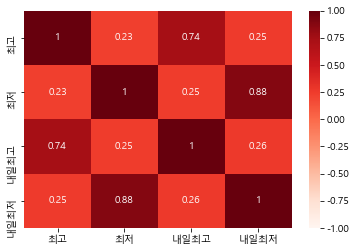

In [70]:
sns.heatmap(df_merge.corr(), cmap='Reds', annot=True, vmin=-1, vmax=1)
plt.show()

In [6]:
#문자열 dummies로 분류
df_dummies = pd.get_dummies(df_merge, columns=['도시','날씨'], dtype='float')
df_dummies

,날짜,최고,최저,내일최고,내일최저,도시_가평,도시_강화,도시_고양,도시_과천,도시_광명,...,도시_의정부,도시_이천,도시_인천,도시_파주,도시_평택,도시_포천,도시_하남,도시_화성,날씨_구름많음,날씨_맑음
0,2021-07-26 00:00:00,34,26,35,25,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2021-07-26 12:00:00,34,26,35,25,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2021-07-27 00:00:00,35,25,34,25,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2021-07-27 12:00:00,35,25,34,25,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2021-07-28 00:00:00,34,25,34,25,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,2021-07-29 00:00:00,33,23,33,23,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
381,2021-07-29 12:00:00,33,23,33,23,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
382,2021-07-30 00:00:00,33,23,32,24,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
383,2021-07-31 00:00:00,32,24,33,24,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [7]:
x_data = df_dummies.drop(columns = ['내일최고', '내일최저', '날짜'])
y_data = df_dummies[['내일최고','내일최저']]

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, 
                                                    stratify=y_data, random_state=1)

In [9]:
model_lr = make_pipeline(StandardScaler(), LinearRegression() )
model_lr.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [10]:
model_lr.score(x_train, y_train)

0.7974686012713218

In [11]:
model_lr.score(x_test, y_test)

0.7896765399995738

In [12]:
# 실제값 예측값 비교
print(model_lr.predict(x_data.iloc[[-1]]))
print(y_data.iloc[[-1]])

[[32.27691894 23.28977574]]
     내일최고  내일최저
384    31    24


### 문제2) 지역별 날씨 평균

In [ ]:
df.groupby('도시').mean()

In [41]:
city_high = pd.DataFrame(df.groupby('도시')['최고'].mean())
city_low = pd.DataFrame(df.groupby('도시')['최저'].mean())

In [42]:
city_weather_mean = pd.merge(city_low, city_high, left_index=True,  right_index=True)
city_weather_mean

,최저,최고
도시,,
가평,22.384615,33.692308
강화,24.000000,31.076923
고양,24.076923,33.846154
과천,23.846154,33.615385
광명,25.923077,34.153846
광주,23.230769,33.000000
구리,24.538462,33.769231
군포,25.000000,34.230769
김포,25.000000,32.615385


### 문제3) 일교차 심한곳 내림차순

In [46]:
city_weather_mean['일교차'] = city_weather_mean['최고'] - city_weather_mean['최저']
city_weather_mean.sort_values('일교차', ascending=False)

,최저,최고,일교차
도시,,,
연천,22.000000,33.538462,11.538462
가평,22.384615,33.692308,11.307692
의왕,23.153846,33.461538,10.307692
이천,24.000000,34.076923,10.076923
동두천,23.000000,33.076923,10.076923
파주,23.923077,33.846154,9.923077
양평,23.230769,33.076923,9.846154
오산,24.076923,33.923077,9.846154
고양,24.076923,33.846154,9.769231


### 문제4) 최고최저 평균 기온 날짜별로 시계열 그래프

In [103]:
high = pd.DataFrame(df.groupby('날짜')['최고'].mean())
low = pd.DataFrame(df.groupby('날짜')['최저'].mean())
high

,최고
날짜,
2021-07-26 00:00:00,34.000000
2021-07-26 12:00:00,34.000000
2021-07-27 00:00:00,33.257143
2021-07-27 12:00:00,33.257143
2021-07-28 00:00:00,32.628571
2021-07-28 12:00:00,32.628571
2021-07-29 00:00:00,33.257143
2021-07-29 12:00:00,33.257143
2021-07-30 00:00:00,33.200000


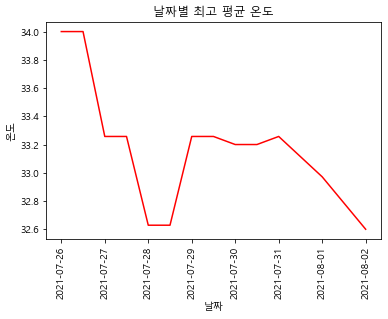

In [117]:
plt.xticks(rotation=90)
plt.plot(high['최고'],'r')
plt.title('날짜별 최고 평균 온도')
plt.xlabel('날짜')
plt.ylabel('온도')
plt.show()

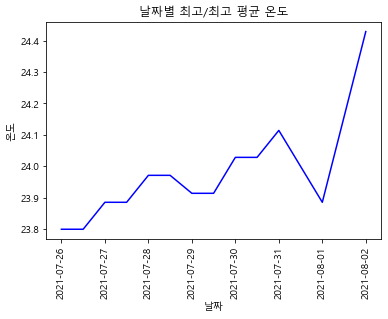

In [116]:
plt.xticks(rotation=90)
plt.plot(low['최저'],'b')
plt.title('날짜별 최저 평균 온도')
plt.xlabel('날짜')
plt.ylabel('온도')
plt.show()